
# AAI612: Deep Learning & its Applications

*Notebook 4.1: American Sign Language with Convolution**

<a href="https://colab.research.google.com/github/jgeitani/AAI612_Geitani/blob/main/Week4/JadGeitani_Notebook4.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

In the previous week, we built and trained a simple model to classify ASL images. The model was able to learn how to correctly classify the training dataset with very high accuracy, but, it did not perform nearly as well on validation dataset. This behavior of not generalizing well to non-training data is called [overfitting](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html), and in this section, we will introduce a popular kind of model called a [convolutional neural network](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) that is especially good for reading images and classifying them.

## Objectives

* Prep data specifically for a CNN
* Create a more sophisticated CNN model, understanding a greater variety of model layers
* Train a CNN model and observe its performance

## Loading and Preparing the Data

The below cell contains the data preprocessing techniques we learned in the previous labs. Review it and execute it before moving on:

In [1]:
import tensorflow.keras as keras
import pandas as pd
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# Load in our data from CSV files
train_df = pd.read_csv("https://raw.githubusercontent.com/harmanani/AAI612/main/Week4/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("https://raw.githubusercontent.com/harmanani/AAI612/main/Week4/asl_data/sign_mnist_valid.csv")

# Separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# Separate out our image vectors
x_train = train_df.values
x_valid = valid_df.values

# Turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

## Reshaping Images for a CNN

In the last exercise, the individual pictures in our dataset are in the format of long lists of 784 pixels:

In [2]:
x_train.shape, x_valid.shape

((27455, 784), (7172, 784))

In this format, we don't have all the information about which pixels are near each other. Because of this, we can't apply convolutions that will detect features. Let's reshape our dataset so that they are in a 28x28 pixel format. This will allow our convolutions to associate groups of pixels and detect important features.

Note that for the first convolutional layer of our model, we need to have not only the height and width of the image, but also the number of [color channels](https://www.photoshopessentials.com/essentials/rgb/). Our images are grayscale, so we'll just have 1 channel.

That means that we need to convert the current shape `(27455, 784)` to `(27455, 28, 28, 1)`. As a convenience, we can pass the [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html#numpy.reshape) method a `-1` for any dimension we wish to remain the same, therefore:

In [3]:
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

In [4]:
x_train.shape

(27455, 28, 28, 1)

In [5]:
x_valid.shape

(7172, 28, 28, 1)

In [6]:
x_train.shape, x_valid.shape

((27455, 28, 28, 1), (7172, 28, 28, 1))

## Creating a Convolutional Model

These days, many data scientists start their projects by borrowing model properties from a similar project. Assuming the problem is not totally unique, there's a great chance that people have created models that will perform well which are posted in online repositories like [TensorFlow Hub](https://www.tensorflow.org/hub) and the [NGC Catalog](https://ngc.nvidia.com/catalog/models). Today, we'll provide a model that will work well for this problem.

<img src="images/cnn.png" width=180 />

We covered many of the different kinds of layers in the lecture, and we will go over them all here with links to their documentation. When in doubt, read the official documentation (or ask [stackoverflow](https://stackoverflow.com/)).

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

<img src="images/conv2d.png" width=300 />

These are our 2D convolutional layers. Small kernels will go over the input image and detect features that are important for classification. Earlier convolutions in the model will detect simple features such as lines. Later convolutions will detect more complex features. Let's look at our first Conv2D layer:
```Python
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same'...)
```
75 refers to the number of filters that will be learned. (3,3) refers to the size of those filters. Strides refer to the step size that the filter will take as it passes over the image. Padding refers to whether the output image that's created from the filter will match the size of the input image.

### [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)

Like normalizing our inputs, batch normalization scales the values in the hidden layers to improve training. [Read more about it in detail here](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/).

### [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)

<img src="images/maxpool2d.png" width=300 />
Max pooling takes an image and essentially shrinks it to a lower resolution. It does this to help the model be robust to translation (objects moving side to side), and also makes our model faster.

### [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

<img src="images/dropout.png" width=360 />
Dropout is a technique for preventing overfitting. Dropout randomly selects a subset of neurons and turns them off, so that they do not participate in forward or backward propagation in that particular pass. This helps to make sure that the network is robust and redundant, and does not rely on any one area to come up with answers.    

### [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)

Flatten takes the output of one layer which is multidimensional, and flattens it into a one-dimensional array. The output is called a feature vector and will be connected to the final classification layer.

### [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

We have seen dense layers before in our earlier models. Our first dense layer (512 units) takes the feature vector as input and learns which features will contribute to a particular classification. The second dense layer (24 units) is the final classification layer that outputs our prediction.

## Summarizing the Model

This may feel like a lot of information, but don't worry. It's not critical that to understand everything right now in order to effectively train convolutional models. Most importantly we know that they can help with extracting useful information from images, and can be used in classification tasks.

Here, we summarize the model we just created. Notice how it has fewer trainable parameters than the model in the previous notebook:

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 75)          │             750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 75)          │             300 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 75)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 50)          │          33,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 50)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 50)          │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 50)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 25)            │          11,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 25)            │             100 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 25)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         205,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │          12,312 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,049 (1.01 MB)

 Trainable params: 263,749 (1.01 MB)

 Non-trainable params: 300 (1.17 KB)

## Compiling the Model

We'll compile the model just like before:

In [9]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

## Training the Model

Despite the very different model architecture, the training looks exactly the same. Run the cell below to train for 20 epochs and let's see if the accuracy improves:

In [10]:
history = model.fit(x_train, y_train, epochs=20, verbose=1, validation_data=(x_valid, y_valid))

Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 122s 138ms/step - accuracy: 0.7496 - loss: 0.8586 - val_accuracy: 0.8660 - val_loss: 0.4985
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 118s 138ms/step - accuracy: 0.9941 - loss: 0.0193 - val_accuracy: 0.9131 - val_loss: 0.3695
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 110s 128ms/step - accuracy: 0.9961 - loss: 0.0107 - val_accuracy: 0.9011 - val_loss: 0.3508
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 149s 137ms/step - accuracy: 0.9976 - loss: 0.0075 - val_accuracy: 0.9534 - val_loss: 0.2142
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 114s 133ms/step - accuracy: 0.9984 - loss: 0.0042 - val_accuracy: 0.8720 - val_loss: 0.6434
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 120s 140ms/step - accuracy: 0.9986 - loss: 0.0042 - val_accuracy: 0.9495 - val_loss: 0.1959
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 130s 126ms/step - accuracy: 0.9995 - loss: 0.0013 - val_accuracy: 0.9498 - val_loss: 0.2742
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 116s 135ms/step - accuracy: 0.9999 -

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


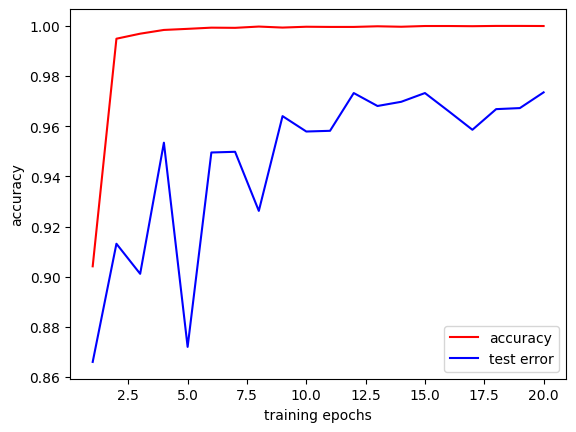

In [11]:
chart_x = range(1,21)
chart_y_train = history.history['accuracy']
chart_y_test = history.history['val_accuracy']
print(history.history.keys())
import matplotlib.pyplot as plt

def plot_learning():
    plt.plot(chart_x, chart_y_train, 'r-',label='accuracy')
    plt.plot(chart_x, chart_y_test, 'b-',
    label='test error')
    #plt.axis([0, len(chart_x), 0.0, 1.0])
    plt.xlabel('training epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
plot_learning()

## Discussion of Results

It looks like this model is significantly improved! The training accuracy is very high, and the validation accuracy has improved as well. This is a great result, as all we had to do was swap in a new model.

You may have noticed the validation accuracy jumping around. This is an indication that our model is still not generalizing perfectly. Fortunately, there's more that we can do. Let's talk about it in the next lecture.

## Summary

In this section, we utilized several new kinds of layers to implement a CNN, which performed better than the more simple model used in the last section. Hopefully the overall process of creating and training a model with prepared data is starting to become even more familiar.

## Next

In the last several sections you have focused on the creation and training of models. In order to further improve performance, you will now turn your attention to *data augmentation*, a collection of techniques that will allow your models to train on more and better data than what you might have originally at your disposal.

In [12]:

import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

# Function to define and train a modified CNN model
def train_modified_model(modifications):
    results = []
    for mod in modifications:
        # Define the model
        model = Sequential()
        model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", input_shape=(28, 28, 1)))
        model.add(BatchNormalization())
        model.add(MaxPool2D((2, 2), strides=2, padding="same"))

        # Adding extra layers as per modifications
        for filters, dropout_rate in mod["extra_layers"]:
            model.add(Conv2D(filters, (3, 3), strides=1, padding="same", activation="relu"))
            model.add(BatchNormalization())
            model.add(MaxPool2D((2, 2), strides=2, padding="same"))
            if dropout_rate > 0:
                model.add(Dropout(dropout_rate))

        model.add(Flatten())
        model.add(Dense(units=512, activation="relu"))
        model.add(Dropout(mod["final_dropout"]))
        model.add(Dense(units=num_classes, activation="softmax"))

        # Compile the model
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

        # Train the model and record training time
        start_time = time.time()
        history = model.fit(x_train, y_train, epochs=5, verbose=1, validation_data=(x_valid, y_valid))
        training_time = time.time() - start_time

        # Record results
        final_accuracy = history.history['val_accuracy'][-1]
        results.append({
            "extra_layers": len(mod["extra_layers"]),
            "parameters": mod,
            "accuracy": final_accuracy,
            "training_time": training_time,
        })

    return results


# Define modifications to test (adding layers and tweaking dropout)
modifications = [
    {"extra_layers": [(50, 0.2)], "final_dropout": 0.3},  # Add 1 extra Conv2D layer
    {"extra_layers": [(50, 0.2), (25, 0.2)], "final_dropout": 0.3},  # Add 2 extra Conv2D layers
    {"extra_layers": [(100, 0.3), (50, 0.2), (25, 0.1)], "final_dropout": 0.4},  # Add 3 extra Conv2D layers
]

# Train and collect results
results = train_modified_model(modifications)

# Display results in a clear format
import pandas as pd
results_df = pd.DataFrame(results)
results_df


Epoch 1/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 125s 142ms/step - accuracy: 0.7535 - loss: 1.0653 - val_accuracy: 0.9204 - val_loss: 0.4028
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 116s 135ms/step - accuracy: 0.9909 - loss: 0.0337 - val_accuracy: 0.8610 - val_loss: 1.1194
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 147s 140ms/step - accuracy: 0.9956 - loss: 0.0147 - val_accuracy: 0.9303 - val_loss: 0.3770
Epoch 4/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 141s 140ms/step - accuracy: 0.9983 - loss: 0.0074 - val_accuracy: 0.9201 - val_loss: 0.6239
Epoch 5/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 139s 136ms/step - accuracy: 0.9977 - loss: 0.0102 - val_accuracy: 0.9137 - val_loss: 0.8204
Epoch 1/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 125s 142ms/step - accuracy: 0.6718 - loss: 1.1206 - val_accuracy: 0.9303 - val_loss: 0.2616
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 138s 138ms/step - accuracy: 0.9801 - loss: 0.0565 - val_accuracy: 0.8151 - val_loss: 0.8066
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 121s 141ms/step - accuracy: 0.9908 - loss: 0

,extra_layers,parameters,accuracy,training_time
0,1,"{'extra_layers': [(50, 0.2)], 'final_dropout':...",0.913692,693.366172
1,2,"{'extra_layers': [(50, 0.2), (25, 0.2)], 'fina...",0.930145,689.420572
2,3,"{'extra_layers': [(100, 0.3), (50, 0.2), (25, ...",0.966815,962.338458


In [13]:

import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
import pandas as pd

# Function to define and train a modified CNN model
def train_modified_model(modifications):
    results = []
    for mod in modifications:
        # Define the model
        model = Sequential()
        model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", input_shape=(28, 28, 1)))
        model.add(BatchNormalization())
        model.add(MaxPool2D((2, 2), strides=2, padding="same"))

        # Adding extra layers as per modifications
        for filters, dropout_rate in mod["extra_layers"]:
            model.add(Conv2D(filters, (3, 3), strides=1, padding="same", activation="relu"))
            model.add(BatchNormalization())
            model.add(MaxPool2D((2, 2), strides=2, padding="same"))
            if dropout_rate > 0:
                model.add(Dropout(dropout_rate))

        model.add(Flatten())
        model.add(Dense(units=512, activation="relu"))
        model.add(Dropout(mod["final_dropout"]))
        model.add(Dense(units=num_classes, activation="softmax"))

        # Compile the model
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

        # Train the model and record training time
        start_time = time.time()
        history = model.fit(x_train, y_train, epochs=5, verbose=1, validation_data=(x_valid, y_valid))
        training_time = time.time() - start_time

        # Record results
        final_accuracy = history.history['val_accuracy'][-1]
        results.append({
            "extra_layers": len(mod["extra_layers"]),
            "parameters": mod,
            "accuracy": final_accuracy,
            "training_time": training_time,
        })

    return results

# Define modifications to test (adding layers and tweaking dropout)
modifications = [
    {"extra_layers": [(50, 0.2)], "final_dropout": 0.3},  # Add 1 extra Conv2D layer
    {"extra_layers": [(50, 0.2), (25, 0.2)], "final_dropout": 0.3},  # Add 2 extra Conv2D layers
    {"extra_layers": [(100, 0.3), (50, 0.2), (25, 0.1)], "final_dropout": 0.4},  # Add 3 extra Conv2D layers
]

# Train and collect results
results = train_modified_model(modifications)

# Save results as a dataframe
results_df = pd.DataFrame(results)
results_df


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 137s 157ms/step - accuracy: 0.7527 - loss: 1.1286 - val_accuracy: 0.8021 - val_loss: 0.9936
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 132s 145ms/step - accuracy: 0.9923 - loss: 0.0268 - val_accuracy: 0.9221 - val_loss: 0.4070
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 151s 156ms/step - accuracy: 0.9967 - loss: 0.0108 - val_accuracy: 0.8475 - val_loss: 1.2866
Epoch 4/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 141s 155ms/step - accuracy: 0.9970 - loss: 0.0093 - val_accuracy: 0.6845 - val_loss: 4.0611
Epoch 5/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 134s 146ms/step - accuracy: 0.9983 - loss: 0.0056 - val_accuracy: 0.8986 - val_loss: 0.6539
Epoch 1/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 130s 148ms/step - accuracy: 0.6728 - loss: 1.1161 - val_accuracy: 0.9388 - val_loss: 0.1806
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 142s 147ms/step - accuracy: 0.9791 - loss: 0.0588 - val_accuracy: 0.9419 - val_loss: 0.2127
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 143s 148ms/step - accuracy: 0.9918 - loss: 0

,extra_layers,parameters,accuracy,training_time
0,1,"{'extra_layers': [(50, 0.2)], 'final_dropout':...",0.898634,695.194153
1,2,"{'extra_layers': [(50, 0.2), (25, 0.2)], 'fina...",0.962354,690.037976
2,3,"{'extra_layers': [(100, 0.3), (50, 0.2), (25, ...",0.943112,969.156035
